<a href="https://www.kaggle.com/code/sayidheykal/classification-water-quality?scriptVersionId=213338218" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# **Water Quality Prediction for Public Health Protection**

## **Goal**

The primary goal of this project is to protect public health by identifying unsafe water sources to help prevent waterborne diseases. By leveraging machine learning techniques, the project aims to build a predictive model that determines whether water is potable (safe for consumption) or non-potable (unsafe).

>**This project has the potential to contribute meaningfully to public health protection, ensuring safer water supplies for communities worldwide.**

In [2]:
!python --version

Python 3.10.14


In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from pandas.plotting import scatter_matrix

from IPython.display import display
import os

import warnings
warnings.filterwarnings("ignore")

# **Data Loading**

In [5]:
INPUT_DIR = '/kaggle/input/water-potability/'
WORKING_DIR = '/kaggle/working/'

input_dataset = os.path.join(INPUT_DIR, 'water_potability.csv')
df = pd.read_csv(input_dataset)
df.head()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,NaN,204.890455,20791.318981,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135,0
1,3.716080,129.422921,18630.057858,6.635246,NaN,592.885359,15.180013,56.329076,4.500656,0
2,8.099124,224.236259,19909.541732,9.275884,NaN,418.606213,16.868637,66.420093,3.055934,0
3,8.316766,214.373394,22018.417441,8.059332,356.886136,363.266516,18.436524,100.341674,4.628771,0
4,9.092223,181.101509,17978.986339,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075,0


In [6]:
display(df.info())
display(df.describe().T)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3276 entries, 0 to 3275
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ph               2785 non-null   float64
 1   Hardness         3276 non-null   float64
 2   Solids           3276 non-null   float64
 3   Chloramines      3276 non-null   float64
 4   Sulfate          2495 non-null   float64
 5   Conductivity     3276 non-null   float64
 6   Organic_carbon   3276 non-null   float64
 7   Trihalomethanes  3114 non-null   float64
 8   Turbidity        3276 non-null   float64
 9   Potability       3276 non-null   int64  
dtypes: float64(9), int64(1)
memory usage: 256.1 KB


None

,count,mean,std,min,25%,50%,75%,max
ph,2785.0,7.080795,1.594320,0.000000,6.093092,7.036752,8.062066,14.000000
Hardness,3276.0,196.369496,32.879761,47.432000,176.850538,196.967627,216.667456,323.124000
Solids,3276.0,22014.092526,8768.570828,320.942611,15666.690297,20927.833607,27332.762127,61227.196008
Chloramines,3276.0,7.122277,1.583085,0.352000,6.127421,7.130299,8.114887,13.127000
Sulfate,2495.0,333.775777,41.416840,129.000000,307.699498,333.073546,359.950170,481.030642
Conductivity,3276.0,426.205111,80.824064,181.483754,365.734414,421.884968,481.792304,753.342620
Organic_carbon,3276.0,14.284970,3.308162,2.200000,12.065801,14.218338,16.557652,28.300000
Trihalomethanes,3114.0,66.396293,16.175008,0.738000,55.844536,66.622485,77.337473,124.000000
Turbidity,3276.0,3.966786,0.780382,1.450000,3.439711,3.955028,4.500320,6.739000
Potability,3276.0,0.390110,0.487849,0.000000,0.000000,0.000000,1.000000,1.000000


**SUMMARY** <br>
- All datatypes has declared as the content
- For convenient column names would replace into lowercase
- The dataset has a missing values which we'll handle it later
- Almost in every features indicates a big differences range of values between max value and Q3 Value. Which potentially indicated as *outliers*.
- Ununiformed scale of feature values, which is normal and we'll handle it in normalization section.

**STEPS** <br>
- Replace column names into lowercase
- Handling Missing values
- EDA (Identify patterns, correlations, or outliers)
- Scaling a values

The data splitted to train and test in the beginning of analysis, so we can focus to do analysis on training data withoud leaking the test set. But the data should be splitted porpotional, so the data on train set and test set splitted by the same distribtuion. Library scikit learn has provided this method named as `StratifiedShuffleSplit`.

In [8]:
from sklearn.model_selection import StratifiedShuffleSplit

strat_split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_index, test_index in strat_split.split(df, df['Potability']):
    train_split = df.iloc[train_index]
    test_split = df.iloc[test_index]

train_data = train_split.drop(columns=['Potability'])
train_target = train_split['Potability']

test_data = test_split.drop(columns=['Potability'])
test_target = test_split['Potability']

train_split.shape, test_split.shape, train_target.shape, test_target.shape

((2620, 10), (656, 10), (2620,), (656,))

# **Data Cleansing**

The data we are dealing right now is not clean enough, it might causes the model quality. As we listed above we will do the cleaning process step by step. And right now, we'll make the column name unified as lowercase.

Other than that. We're using the inheritent from the `TransformerMixin` from scikit-learn library, because we'll the cleaning prosess as a scikit-learn pipeline

## **1. Lowercasing Column Names**

In [9]:
class LowerColumnNames(TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X.columns = X.columns.str.lower()
        return X

train_cleaned = train_data.copy()
print(f"Columns before lowercased:\n \33[32m{df.columns}\33[0m\n")
train_cleaned = LowerColumnNames().fit_transform(train_cleaned)

print(f"Columns after lowercased:\n \33[32m{train_cleaned.columns}\33[0m\n")
train_cleaned.info()

train_split = LowerColumnNames().fit_transform(train_split)

Columns before lowercased:
 Index(['ph', 'Hardness', 'Solids', 'Chloramines', 'Sulfate', 'Conductivity',
       'Organic_carbon', 'Trihalomethanes', 'Turbidity', 'Potability'],
      dtype='object')

Columns after lowercased:
 Index(['ph', 'hardness', 'solids', 'chloramines', 'sulfate', 'conductivity',
       'organic_carbon', 'trihalomethanes', 'turbidity'],
      dtype='object')

<class 'pandas.core.frame.DataFrame'>
Index: 2620 entries, 2214 to 264
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ph               2233 non-null   float64
 1   hardness         2620 non-null   float64
 2   solids           2620 non-null   float64
 3   chloramines      2620 non-null   float64
 4   sulfate          1995 non-null   float64
 5   conductivity     2620 non-null   float64
 6   organic_carbon   2620 non-null   float64
 7   trihalomethanes  2486 non-null   float64
 8   turbidity        2620 non-null   float64
dtypes

## **Handling Missing Values**

In [13]:
missing_values = train_cleaned.isna().sum()
print(f'Missing values:\n-------------\n{missing_values}')

Missing values:
-------------
ph                 387
hardness             0
solids               0
chloramines          0
sulfate            625
conductivity         0
organic_carbon       0
trihalomethanes    134
turbidity            0
dtype: int64


There some columns that indicated misisng values. We'll look deep with visualizaiona as below

,features,count_missing
0,ph,387
1,hardness,0
2,solids,0
3,chloramines,0
4,sulfate,625
5,conductivity,0
6,organic_carbon,0
7,trihalomethanes,134
8,turbidity,0


Number of rows with missing values: 1013
Percentage of all missing values: 38.66%


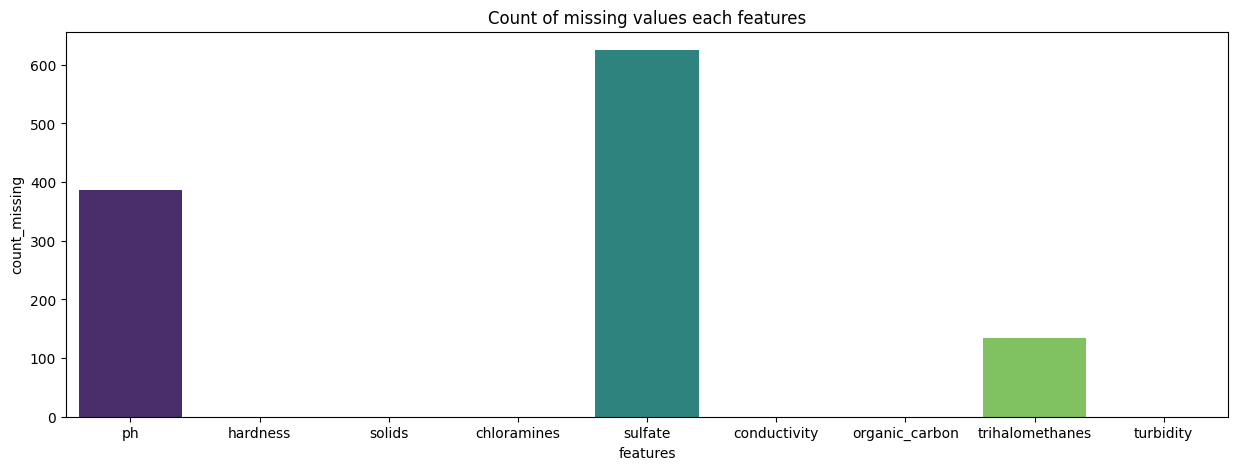

In [14]:
def plot_missing_values(df):
    missing_values = df.isna().sum()
    missing_values_df = missing_values.reset_index().rename(
        columns={'index':'features', 0:'count_missing'}
    )
    
    rows_with_nan = df[df.isnull().any(axis=1)]
    missing_values_percentage = len(rows_with_nan) / len(df) * 100
    
    display(missing_values_df)
    
    print(f'Number of rows with missing values: {len(rows_with_nan)}')
    print(f'Percentage of all missing values: {missing_values_percentage:.2f}%')
    
    plt.figure(figsize=(15,5))
    sns.barplot(missing_values_df, x='features', y='count_missing', palette='viridis')
    plt.title('Count of missing values each features')

plot_missing_values(train_cleaned)

**SUMMARY** :<br>
- Missing values are reaching up to 38% of data, which is high. 
- We should use the appropriate method for handling. However, dropping it might causes loss a lot of information. Hence, the only way we going to do is the imputation.
- Due to the dataset is crusial for imputation to be a pricise value (In terms of our dataset contains public health quality). Doing a simple imputation might causes a bias. Hence, we will do the multiple imputation

**STRATEGY**: <br>
- Implement MICE (Multiple Imputation by Chained Equations). Ref of explanation from <a href="https://www.machinelearningplus.com/machine-learning/mice-imputation/">Here.</a>
- Using `IterativeImputer` method from `sklearn` library to apply multiple imputer on missing values. To do that, the prediction values will apply as n-times, which it generates new dataset with different random values each.
- Use a final dataset to train model.

,features,count_missing
0,ph,0
1,hardness,0
2,solids,0
3,chloramines,0
4,sulfate,0
5,conductivity,0
6,organic_carbon,0
7,trihalomethanes,0
8,turbidity,0


Number of rows with missing values: 0
Percentage of all missing values: 0.00%


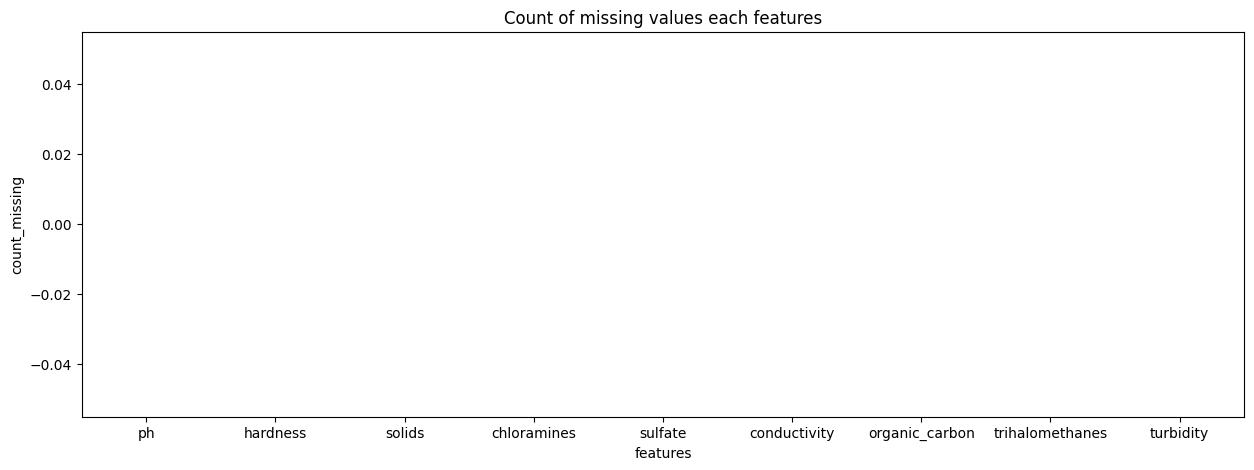

In [15]:
# explicitly require this experimental feature
from sklearn.experimental import enable_iterative_imputer  # noqa
# now you can import normally from sklearn.impute
from sklearn.impute import IterativeImputer

class MultipleImputer(TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        imp = IterativeImputer(random_state=9122024)
        return pd.DataFrame(imp.fit_transform(X), columns=features)
        
train_cleaned = MultipleImputer().fit_transform(train_cleaned)

plot_missing_values(train_cleaned)

# **EDA**

As we will create a model based on our data, we will explore and gain the information from our data. So we can understand better how our data is created.

## **1. Distribution**

As a starter for exploration, let's see the distribution values of each features of our data

In [22]:
train_cleaned.describe().T

,count,mean,std,min,25%,50%,75%,max
ph,2620.0,7.086450,1.471112,0.227499,6.277032,7.065483,7.870050,13.541240
hardness,2620.0,196.520827,32.637713,47.432000,177.228680,196.928061,216.429168,323.124000
solids,2620.0,21888.067749,8760.109347,320.942611,15508.912365,20866.335842,27152.465983,61227.196008
chloramines,2620.0,7.116362,1.599220,0.352000,6.122956,7.118162,8.112651,13.043806
sulfate,2620.0,333.970828,36.540508,129.000000,316.021211,334.161181,350.555305,481.030642
conductivity,2620.0,427.915853,80.943805,181.483754,367.438656,424.941336,484.109323,753.342620
organic_carbon,2620.0,14.272735,3.296556,2.200000,12.053684,14.214780,16.541731,27.006707
trihalomethanes,2620.0,66.141737,15.795184,0.738000,56.342391,66.259507,76.345435,124.000000
turbidity,2620.0,3.973783,0.780342,1.492207,3.439608,3.969602,4.495065,6.739000


In [16]:
def plot_cols_dist(df, columns, suptitle="Features distribution"):
    """Plot the distribution of the specified columns in the DataFrame."""
    if len(columns) == 1:
        n_cols = 1
        n_rows = 1
    else:
        n_cols = 5
        n_rows = len(columns) // n_cols + (1 if len(columns) % n_cols > 0 else 0)

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, n_rows * 5), constrained_layout=True)
    axes = axes.flatten()  # Flatten the axes array for easy indexing
    plt.suptitle(suptitle)
    for i, col in enumerate(columns):
        sns.histplot(df[col], kde=True, ax=axes[i], color="blue", bins=30)
        axes[i].set_title(f"Distribution of {col}")
        axes[i].set_xlabel(col)
        axes[i].set_ylabel("Frequency")

    # Remove any unused axes
    for j in range(len(columns), len(axes)):
        fig.delaxes(axes[j])

    plt.show()

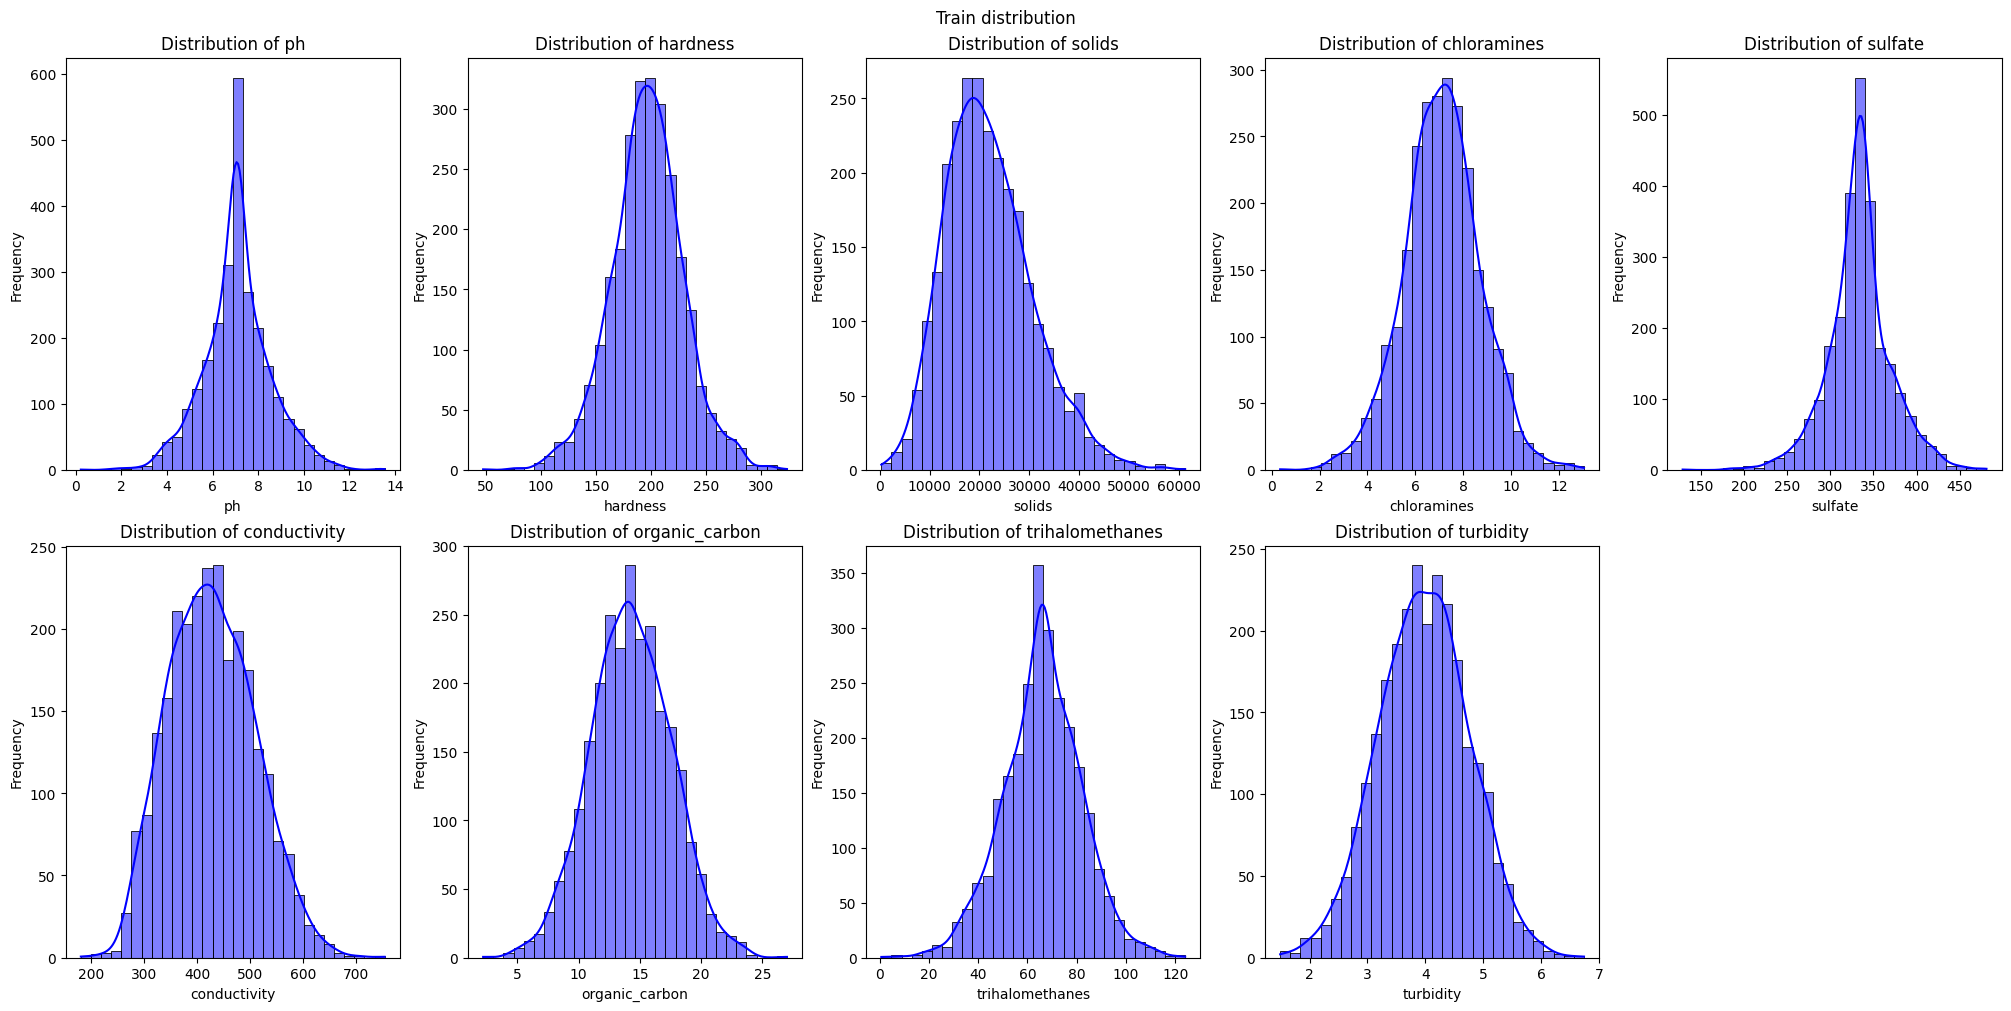

None

<Axes: >

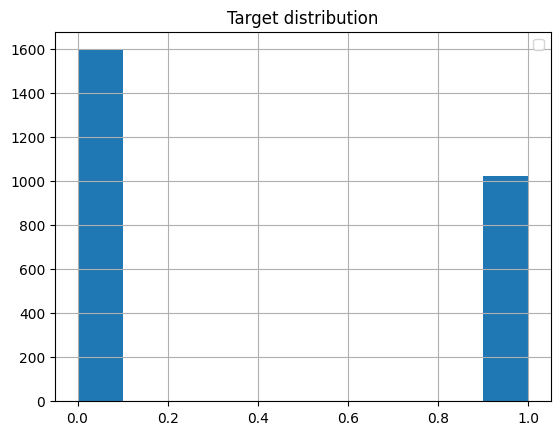

In [19]:
display(plot_cols_dist(train_cleaned, columns=features, suptitle="Train distribution"))
display(train_target.hist())
plt.title('Target distribution')
plt.legend()
plt.show()

The distribution looks tend to be a normal distribution as an image shaped as a bell curve. and `solids` column looks like a little to be a skewed-right distribution.

Then if we looked at the second plotting image, the target distribution we can see from that indicated an imbalanced datasets. and to handle that, there is two options on my mind:
1. Upsampling for minority data
2. Adjusting the threshold of probability so we can adjust the value of the evaluation metrics

we'll try both

## **2. Correlation**

Second we'll identify the correlation between features.

None

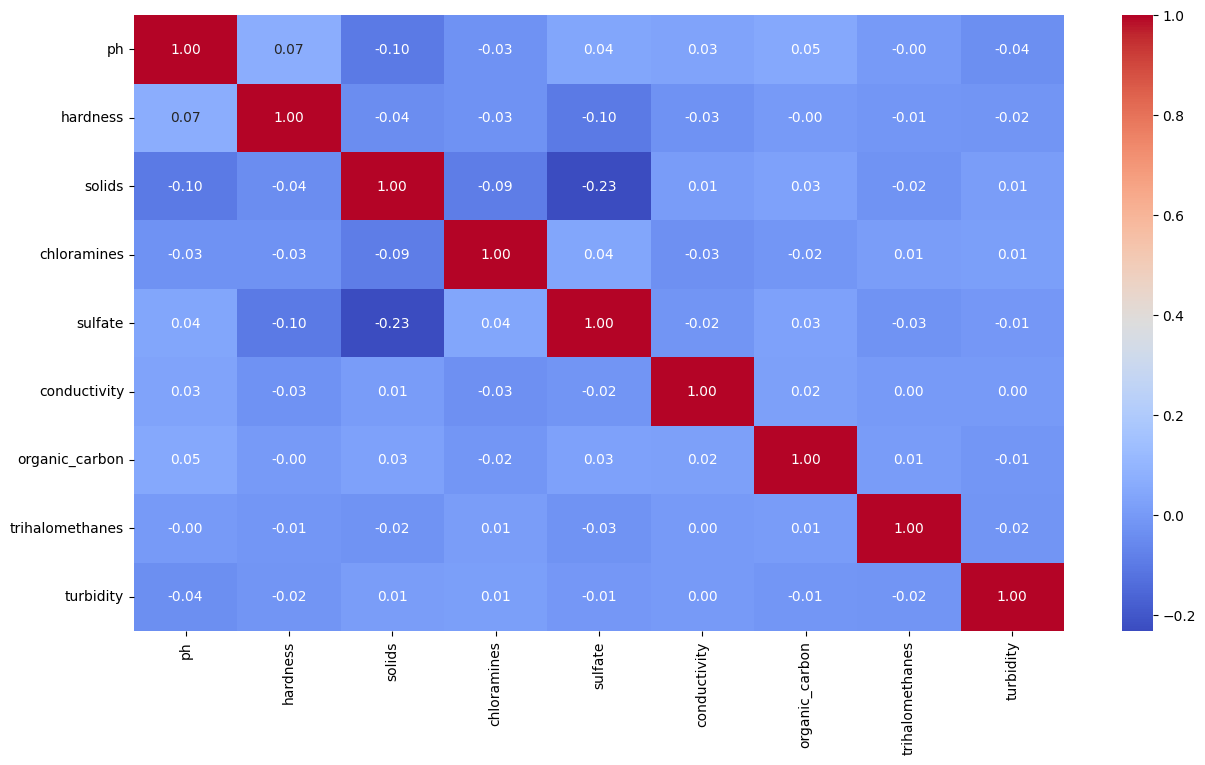

In [26]:
def plot_corr(df):
    mat_corr = df.corr()
    plt.figure(figsize=(15,8))
    sns.heatmap(mat_corr, annot=True, fmt='.2f', cmap='coolwarm')

display(plot_corr(train_cleaned))
plt.show()

There is no so much to see for correlated between columns, but some features like `solid` and `sulfate` indicated as negative correlation between both. as well as `hardness` and `sulfate`, `ph` and `solid`

## **2. Handling an Outliers**

This section when we'll handle the outleirs. Before that we'll look deep to the graph. So we can identify the right solution for the problems

<Figure size 500x800 with 0 Axes>

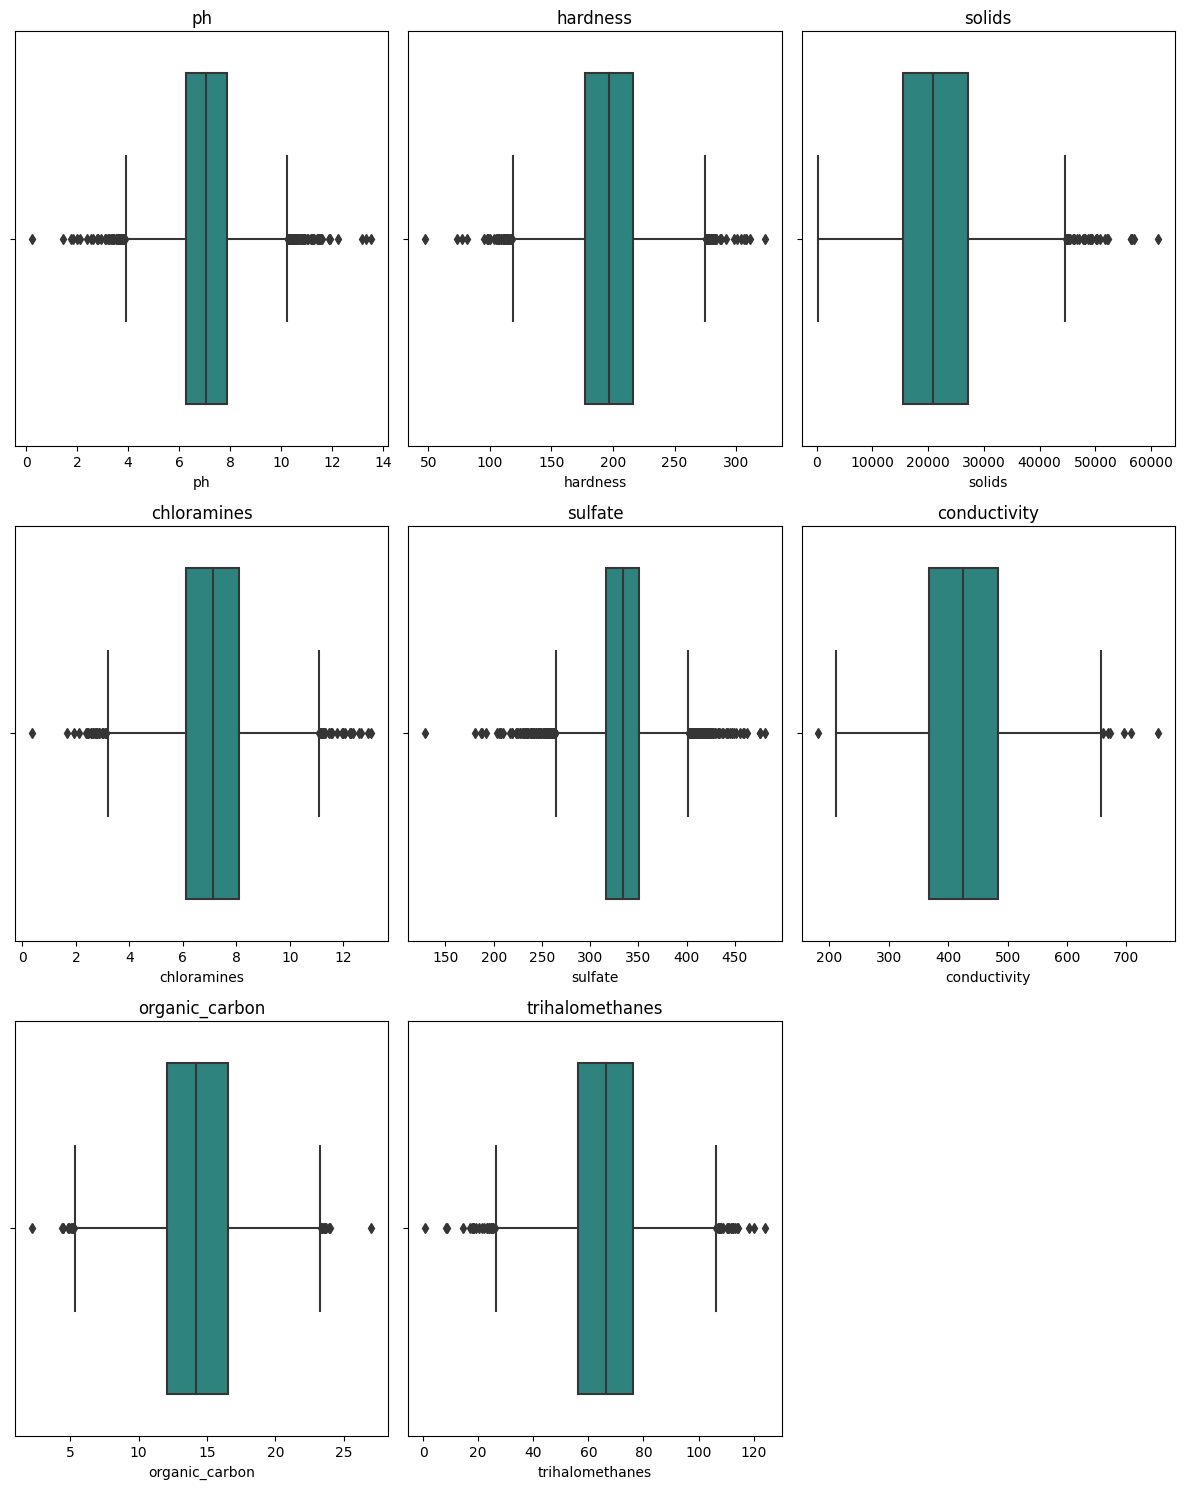

In [27]:
def plot_cols_boxplot(df, features):
    plt.figure(figsize=(5,8))
    
    ncols = 3
    nrows = len(features) // ncols + (1 if len(features) % ncols > 0 else 0)
    fig, axes = plt.subplots(figsize=(12, 5*nrows), nrows=nrows, ncols=ncols)
    
    axes = axes.flatten()
    
    for i, ax in enumerate(axes):
        if i < len(features)-1:  # Check if the index is within bounds, minus 1 for exclude the potability
            sns.boxplot(data=df, x=features[i], ax=ax, palette='viridis')
            ax.set_title(features[i])
        else:
            ax.set_visible(False)
    
    plt.tight_layout()
    plt.show()

plot_cols_boxplot(train_cleaned, features)

,column,Potability,Count
0,ph,potability_0,27
1,hardness,potability_0,34
2,solids,potability_0,19
3,chloramines,potability_0,25
4,sulfate,potability_0,10
5,conductivity,potability_0,6
6,organic_carbon,potability_0,15
7,trihalomethanes,potability_0,14
8,turbidity,potability_0,8
9,potability,potability_0,0


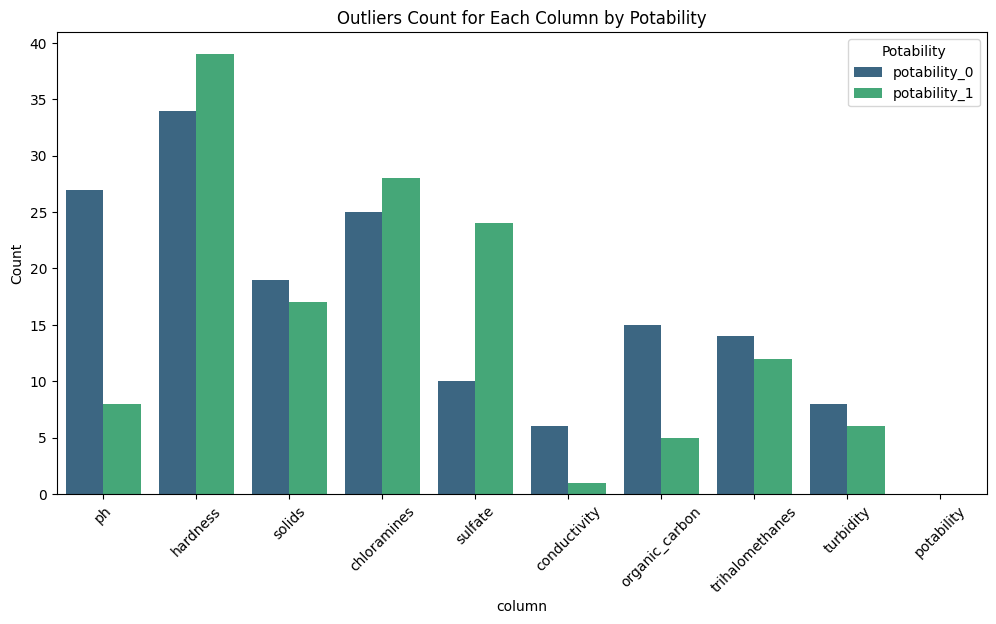

In [28]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Example: Dataset with imputed data (replace train_split with your actual DataFrame)
q1 = train_split.quantile(0.25)
q3 = train_split.quantile(0.75)
iqr = q3 - q1

lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr


# Dictionary to store outliers summary
outliers_summary = {
    'column': [],
    'potability_0': [],
    'potability_1': [],
}

# Calculate outliers for each feature
for col in all_cols:  # Replace 'features' with the list of your feature column names
    outliers = train_split[(train_split[col] < lower_bound[col]) | (train_split[col] > upper_bound[col])]
    outliers_summary['column'].append(col)
    outliers_summary['potability_0'].append(len(outliers[outliers['potability'] == 0]))
    outliers_summary['potability_1'].append(len(outliers[outliers['potability'] == 1]))

# Convert to DataFrame
outliers_summary_df = pd.DataFrame(outliers_summary)

# Melt the DataFrame for better visualization
outliers_summary_melted = outliers_summary_df.melt(id_vars='column', var_name='Potability', value_name='Count')
display(outliers_summary_melted)
# Create a bar plot
plt.figure(figsize=(12, 6))
sns.barplot(data=outliers_summary_melted, x='column', y='Count', hue='Potability', palette='viridis')
plt.title("Outliers Count for Each Column by Potability")
plt.xticks(rotation=45)
plt.show()

In [29]:
# Count if the rows has an existing outliers of column
rows_with_outliers = train_split[train_split[(train_split < lower_bound) | (train_split > upper_bound)].any(axis=1)]
potability_0_outliers = rows_with_outliers[rows_with_outliers['potability'] == 0]
potability_1_outliers = rows_with_outliers[rows_with_outliers['potability'] == 1]

outliers_percentage = len(rows_with_outliers) / len(train_split) * 100
potability_0_outliers_percentage = len(potability_0_outliers) / len(train_split) * 100
potability_1_outliers_percentage = len(potability_1_outliers) / len(train_split) * 100

print(f"Number of rows with outliers: \33[33m{len(rows_with_outliers)}\33[0m")
print(f"Number of potability rows with outliers: \33[33m{len(potability_0_outliers)}\33[0m")
print(f"Number of non-potability rows with outliers: \33[33m{len(potability_1_outliers)}\33[0m\n")
print(f"Percentage of rows with outliers: \33[33m{outliers_percentage:.2f}%\33[0m")
print(f"Percentage of potability rows with outliers: \33[33m{potability_0_outliers_percentage:.2f}%\33[0m")
print(f"Percentage of non-potability with outliers: \33[33m{potability_1_outliers_percentage:.2f}%\33[0m")

Number of rows with outliers: 267
Number of potability rows with outliers: 147
Number of non-potability rows with outliers: 120

Percentage of rows with outliers: 10.19%
Percentage of potability rows with outliers: 5.61%
Percentage of non-potability with outliers: 4.58%


**SUMMARY**: <br>
- The outliers are quite higher as it reaches to 10% of data has been indiceted as an outliers.
- Handling it with removal or transformation makes it poor quality of data. Which in this case related to data of water quality that requires accurate data.

**STRATEGY**: <br>
- Instead of removing or transforming the outliers data, we'll examine it using the robust algorithm like tree-based algorithm `(Decision Tree, Random Forest)`.

# **Preprocessing**

This section we'll perform the preprocessing process for our model. As we describe before, that all step of preprocessing pipeline will be wrapped with classes inherited from `TransfromerMixin` and `BaseEstimator` so we can put our object into the pipeline method that scikit-learn has provied

## **Numerical Cutter Attributes**

This section we'll cut some numerical features into categorical, hoping it might get an useful new features for developing the model quality. This code below apply the process and we'll try the hands-on, so we can see what happend to the process

In [30]:
class NumericalCutterAttribs(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self._columns = columns
    
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        df = X.copy()
        for col in self._columns:
            col_cut = pd.qcut(X[col], 4, labels=[0,1,2,3])
            df[f"{col}_cut"] = col_cut

        return df

# Hands-on example
cutter_attr = NumericalCutterAttribs(features)
train_cut = cutter_attr.fit_transform(train_cleaned)
train_cut.head()

,ph,hardness,solids,chloramines,sulfate,conductivity,organic_carbon,trihalomethanes,turbidity,ph_cut,hardness_cut,solids_cut,chloramines_cut,sulfate_cut,conductivity_cut,organic_carbon_cut,trihalomethanes_cut,turbidity_cut
0,7.822492,208.636720,22308.821729,5.850328,408.123255,502.789396,16.135732,60.393982,3.835332,2,2,2,0,3,3,2,1,1
1,6.037428,227.033994,12988.791229,8.476905,392.380529,306.386283,7.122391,41.190507,3.594217,0,3,0,3,3,0,0,0,1
2,8.445219,228.522860,28966.569327,6.179855,324.251763,361.705354,14.554220,60.612230,4.400706,3,3,3,1,1,0,2,1,2
3,6.745307,218.424637,21871.838700,7.165509,331.713800,373.050102,16.826619,74.086080,3.902353,1,3,2,2,1,1,3,2,1
4,6.506488,202.285938,17087.076902,6.201983,326.662368,481.771934,16.535186,46.205748,3.548776,1,2,1,1,1,2,2,0,1


The result will add a new feautures exctracted from the numerical features

Next, we'll put all in one pipeline. Below is the code how to implement it. The last pipeline is scaling all the values. We'll use `StandardScaler` method, it will normalize all values, so all the `mean` will equal to 0 and `standar deviation` equal to 1

In [33]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# columns that will cut to the categorical feture
columns_to_cut = ["ph", "hardness"]

# store the pipeline processsing.
preproc_pipe = Pipeline([
    ('columns_lowercase', LowerColumnNames()), # lowercase pipeline
    ('imputer', MultipleImputer()), # imputing the missing values
    ('numerical_cutter', NumericalCutterAttribs(columns_to_cut)), # cut numerical into categorical feature
    ('scaler', StandardScaler()) # scaling
])

## **Transform Preprocessing**

Here we'll transform all train and test set with our pipeline

In [34]:
X_train_prepared = preproc_pipe.fit_transform(train_data) # fit preproc transformation for X training
X_test_prepared = preproc_pipe.transform(test_data)# fit preproc transformation for X testing

# below just indicate the target values into new variable and reshape to (-1, 1)
y_train = np.array(train_target).reshape(-1, 1)
y_test = np.array(test_target).reshape(-1, 1)

# **Model Selection**

We'll use 3 different algorithms for our training. it will helps us identify which algorithms are better. we do training with default parameters first. Then we'll se the better result to tune the hyperparameters

In [44]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA

## **Model Training**

Before we jump into training, we'll create the object class and method that we will use many time, so we don't have to write the full codes. This class above just to fit the model using the train and test set that we defined aas initializing constructor. Then we can evaluate using `eval()` method to get the summary of our model. Let's jump in

In [39]:
class TestModels():
    def __init__(self, models, section_name='',
                 split_method=None, 
                 X_train=X_train_prepared, 
                 y_train=y_train, 
                 X_test=X_test_prepared,
                 y_test=y_test):

        self._models=models[0] if len(models) == 1 else [model for model in models]
        self._X_train=X_train
        self._y_train=y_train
        self._X_test=X_test
        self._y_test=y_test
        self._scores={
            'train' : [],
            'test' : []
        }
        self._split_method = split_method
        self._section_name=section_name

        if isinstance(self._models, list):
            model_names = [model.__class__.__name__ for model in self._models]
        else:
            model_names = [self._models.__class__.__name__]

        print(f"Models for selection :\n\33[32m{model_names}\33[0m")
        print(f"split method: \33[32m{self._split_method.__class__.__name__}\33[0m")
        
    def model_fit(self):
        model_fitted = []

        # if number of model is higher than 1 to be trained
        if isinstance(self._models, list):
            for model in self._models:
                model_fitted.append(model.fit(self._X_train, self._y_train))
        else:
            model_fitted.append(self._models.fit(self._X_train, self._y_train))
            
        return model_fitted
        
    def eval(self):
        # return list of models to be evaluated
        models = self.model_fit() 

        # Iterate through each models to be trained, 
        # if just one model then the data is trained once with particular model.
        for model in models:

            # train with split method
            if self._split_method != None:
                sm = self._split_method
                cv_scores = cross_val_score(model, self._X_train, self._y_train, cv=sm, scoring='accuracy')
                # average of cross validation scores
                score_train = cv_scores.mean()
                score_test = accuracy_score(self._y_test, model.predict(self._X_test))
                
            # train without split method
            else:
                score_train = accuracy_score(self._y_train, model.predict(self._X_train))
                score_test = accuracy_score(self._y_test, model.predict(self._X_test))

            # store train and test score
            self._scores['train'].append(score_train)
            self._scores['test'].append(score_test)

        # return the dict type for the results
        return {
                'model_names' : [model.__class__.__name__ for model in models], 
                self._section_name+'_train_scores' : self._scores['train'], 
                self._section_name+'_test_scores':self._scores['test']
               }

In [41]:
%%time
models_dict = {
    'lg' : LogisticRegression(),
    'svm' : SVC(),
    'rf' : RandomForestClassifier(random_state=42),
}

models = [model for model in models_dict.values()]

section_name = 'original'
base_models_test = TestModels(models, section_name=section_name)
models_eval = base_models_test.eval()

score_df = pd.DataFrame(models_eval)
score_df.sort_values(by=[f'{section_name}_train_scores', f'{section_name}_test_scores'], ascending=False)

Models for selection :
['LogisticRegression', 'SVC', 'RandomForestClassifier']
split method: NoneType
CPU times: user 2.09 s, sys: 467 ms, total: 2.56 s
Wall time: 1.82 s


,model_names,original_train_scores,original_test_scores
2,RandomForestClassifier,1.000000,0.685976
1,SVC,0.746565,0.679878
0,LogisticRegression,0.609924,0.609756


`RandomForestClassifier` is indicating the better result than other models result. So next we will use it as our main model that we'll develope

# Resampled data

This as our data is unbalanced, we'll try to resample the minority class and we evaluate how good model can accurately to predict.

In [42]:
def plot_cluster(source, hue, title=''):
    sns.scatterplot(data=source, x=source.columns[0], y=source.columns[1], hue=hue)
    plt.title(title)
    plt.show()

We'll see how the data is distributed in lower dimensional level. Hence, first thing we are going todo is to downgrade the dimensional level into just 2 dimenstion, so it can easily plotted into graph. In this case, we will use the pca method.

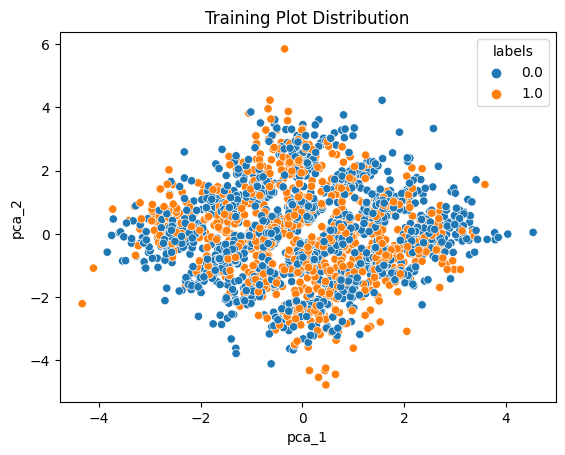

In [46]:
_pca = PCA(n_components=2, random_state=42)
X_train_reduced = _pca.fit_transform(X_train_prepared)

train_reduced = np.c_[X_train_reduced, y_train]
train_reduced_df = pd.DataFrame(train_reduced, columns=['pca_1', 'pca_2', 'labels'])

plot_cluster(train_reduced_df, 'labels', title='Training Plot Distribution')

The plot tells us that the distribution between classes is mixed up. This is quite a problem. Because the model will be more harder in classification. But anyway, we will resample the minority class which is the potable class, so it will equalty distributed with the non potable class. 

In this caae, we'll take the SMOTE (Synthetic Minority Over-sampling Technique) is a popular technique for dealing with class imbalance in machine learning datasets.

In [48]:
from imblearn.over_sampling import SMOTE
from sklearn.utils import shuffle

smote = SMOTE(random_state=42)

# resampling training set
train_resampled = smote.fit_resample(X_train_prepared, y_train)
train_resampled = np.c_[train_resampled[1], train_resampled[0]]
train_resampled = shuffle(train_resampled, random_state=42)

X_train_resampled = train_resampled[:, 1:]
y_train_resampled = train_resampled[:, 0]

X_train_resampled[:5], y_train_resampled[:5]

(array([[ 6.77309189e-01,  5.28150982e-01, -2.26562619e-02,
          1.03534092e+00, -2.44612623e-01,  9.91007648e-01,
          8.39059051e-01,  6.00822048e-04,  1.63209223e+00,
          1.34164079e+00,  4.47213595e-01],
        [-1.57085779e+00, -7.56517644e-03, -3.08534016e-01,
         -1.35931719e+00, -1.32122892e-01,  3.85127112e-01,
         -2.73605813e-01,  1.16782641e+00,  5.23433025e-01,
         -1.34164079e+00, -4.47213595e-01],
        [ 1.70132283e-01, -3.06137275e-01,  3.56159489e-01,
         -8.40040678e-01, -1.25270967e+00,  1.12680660e+00,
         -5.79777511e-01,  5.17597840e-01,  3.68821668e-01,
          7.45602934e-02, -4.47213595e-01],
        [-8.46685266e-01, -5.83464944e-02, -4.75667976e-01,
         -9.19414402e-01,  2.09089666e+00,  2.41012830e+00,
          1.01847093e+00,  1.70520927e+00,  3.38092811e-01,
         -1.34164079e+00, -4.47213595e-01],
        [-2.27593237e-01,  2.10827841e-01,  5.06682841e-01,
          7.81222263e-01,  2.16918730e-01, -

In [49]:
# Resampling test set
test_resampled = smote.fit_resample(X_test_prepared, y_test)
test_resampled = np.c_[test_resampled[1], test_resampled[0]]
test_resampled = shuffle(test_resampled, random_state=42)

X_test_resampled = test_resampled[:, 1:]
y_test_resampled = test_resampled[:, 0]

X_test_resampled[:5], y_test_resampled[:5]

(array([[-0.47479032,  0.04051918, -0.12559927, -0.0538216 ,  0.3413632 ,
          0.52249292, -0.6874182 , -0.158648  , -0.20487916, -0.73279932,
          0.4472136 ],
        [-1.57519337,  0.31114267,  0.7743368 , -1.38002785, -0.44796107,
          0.93464104, -0.06997474, -0.02496656,  1.26684283, -1.34164079,
          0.53054877],
        [-1.6645009 , -0.43213498,  1.41279975, -0.57454362, -0.72569968,
          0.1384169 , -1.97573597,  0.13316748,  0.19322796, -1.34164079,
         -0.4472136 ],
        [-0.8931901 ,  0.51614931,  0.48374653,  0.94711537, -1.66125128,
          0.46514516, -1.90129404, -0.39116875,  3.23056693, -1.34164079,
          0.4472136 ],
        [ 0.33122554,  1.4063903 , -1.38206149, -0.44793524, -3.34266144,
         -0.93809507, -1.17280414,  0.23858364,  0.83686739,  0.4472136 ,
          1.34164079]]),
 array([1., 1., 1., 1., 1.]))

Now we'll look the the resampling distribution in lower dimensional space

<Axes: >

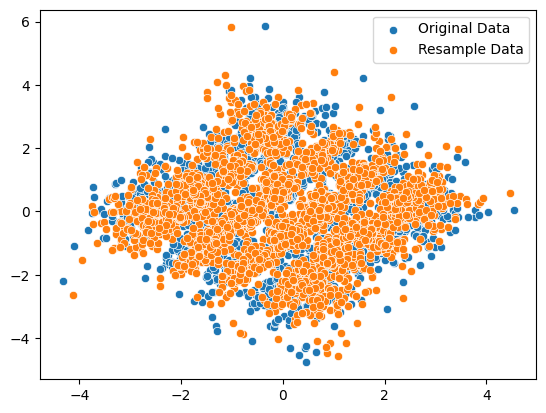

In [50]:
X_train_resampled_reduced = _pca.fit_transform(X_train_resampled)
sns.scatterplot(x=X_train_reduced[:,0],y=X_train_reduced[:, 1], label='Original Data')
sns.scatterplot(x=X_train_resampled_reduced[:, 0], y=X_train_resampled_reduced[:, 1], label='Resample Data')

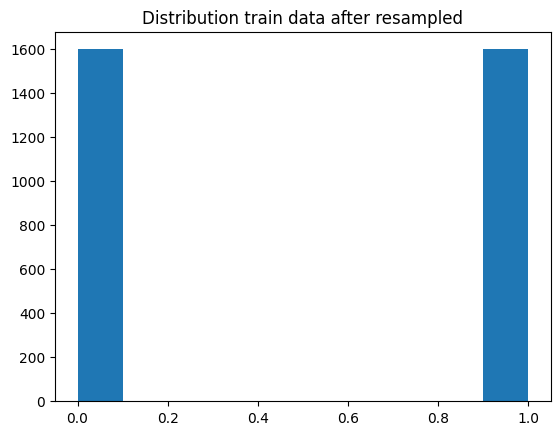

In [51]:
plt.hist(y_train_resampled)
plt.title('Distribution train data after resampled')
plt.show()

In [52]:
# Retraining on resampled data

section_name='resampled'
models_test_resampled = TestModels(models,
                                   section_name=section_name, 
                                   X_train=X_train_resampled, 
                                   y_train=y_train_resampled, 
                                   X_test=X_test_resampled,
                                   y_test=y_test_resampled
                                  )
models_eval_resampled = models_test_resampled.eval()

score_resampled_df = pd.DataFrame(models_eval_resampled)
score_resampled_df.sort_values(by=[f'{section_name}_train_scores', f'{section_name}_test_scores'], ascending=False)

Models for selection :
['LogisticRegression', 'SVC', 'RandomForestClassifier']
split method: NoneType


,model_names,resampled_train_scores,resampled_test_scores
2,RandomForestClassifier,1.000000,0.64875
1,SVC,0.765957,0.62625
0,LogisticRegression,0.509387,0.55250


The result of model testing after resampling is worst than before resampling, it may causes the mixed class between train and test set is more data mixed. Anyway, we'll stick to the dataset before resampling

# Search Tune

In [53]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

In [64]:
%%time
params_rf = {
    'n_estimators' : [100, 150, 250, 850],
    'max_depth' : [25, 35, 85, None],
    'min_samples_split' : [2, 15, 20, 30, 35],
    'min_samples_leaf' : [1, 15, 20]
}

grid_search_rf = GridSearchCV(estimator=models_dict['rf'], 
                                      param_grid=params_rf, 
                                      verbose=1,  
                                      n_jobs=2,
                                      cv=2,
                                      scoring='accuracy', 
                                      return_train_score=True)


grid_search_rf.fit(X_train_prepared, y_train.ravel())

Fitting 2 folds for each of 240 candidates, totalling 480 fits
CPU times: user 3.73 s, sys: 676 ms, total: 4.4 s
Wall time: 6min 2s


GridSearchCV(cv=2, estimator=RandomForestClassifier(random_state=42), n_jobs=2,
             param_grid={'max_depth': [25, 35, 85, None],
                         'min_samples_leaf': [1, 15, 20],
                         'min_samples_split': [2, 15, 20, 30, 35],
                         'n_estimators': [100, 150, 250, 850]},
             return_train_score=True, scoring='accuracy', verbose=1)

In [66]:
search_best = grid_search_rf.best_estimator_
print(search_best)

RandomForestClassifier(max_depth=35, min_samples_split=15, random_state=42)


In [67]:
TestModels([search_best], X_train=X_train_resampled, y_train=y_train_resampled, X_test=X_test_prepared).eval()

Models for selection :
['RandomForestClassifier']
split method: NoneType


{'model_names': ['RandomForestClassifier'],
 '_train_scores': [0.9843554443053817],
 '_test_scores': [0.6722560975609756]}

In [69]:
rf_final = RandomForestClassifier(max_depth=35, min_samples_split=15, random_state=42)
TestModels([rf_final], X_train=X_train_resampled, y_train=y_train_resampled, X_test=X_test_prepared).eval()

Models for selection :
['RandomForestClassifier']
split method: NoneType


{'model_names': ['RandomForestClassifier'],
 '_train_scores': [0.9843554443053817],
 '_test_scores': [0.6722560975609756]}

The best Estimator after grid search is `RandomForestClassifier(max_depth=35, min_samples_split=15, random_state=42)`, with the train and test score `0.98` and `0.67` respectively. It's inddicating as overfit the model in the training. As we use the randomforest that uses the tree-based model which prone to overfit.

Anyway, accuracy scores is not the one we can evaluate the model is good or bad. We'll look deep into evaluation to adjust our model to be more matched to the real solution

# **Evaluation**

In [71]:
from sklearn.model_selection import learning_curve, LearningCurveDisplay
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, PrecisionRecallDisplay

The code below is to store the final train and test dataset that used to be evaluated

In [73]:
X_train_final = X_train_prepared
y_train_final = y_train.ravel() # make one dimensional array

X_test_final = X_test_prepared
y_test_final = y_test.ravel()

X_train_final.shape, X_test_final.shape

((2620, 11), (656, 11))

We've seen the overfit indicator from scoring the train and test set. Below we look deep down to the visualization of that meaning.

In [82]:
def plot_learning_curve(train_scores, test_scores):   
    plt.figure()
    plt.plot(train_sizes, train_scores, 'o-', label="Training score")
    plt.plot(train_sizes, test_scores, 'o-', label="Testing score")
    plt.xlabel("Training Sizes")
    plt.ylabel("Score")
    plt.title("Learning Curve")
    plt.legend(loc="best")
    plt.grid()
    plt.show()

[learning_curve] Training set sizes: [ 471  778 1179 1650 2122]


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  25 out of  50 | elapsed:    7.7s remaining:    7.7s
[Parallel(n_jobs=2)]: Done  50 out of  50 | elapsed:   14.2s finished


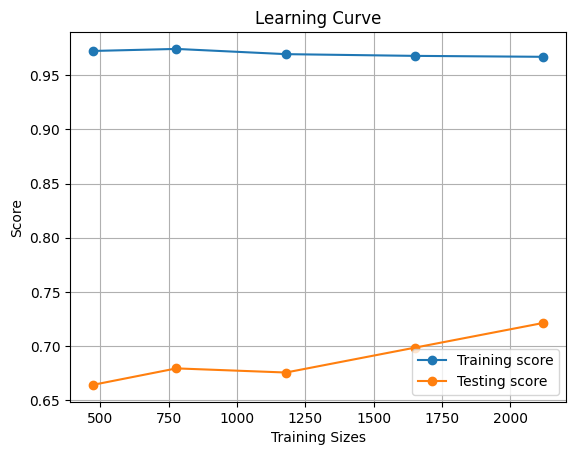

In [83]:
train_sizes, train_scores, test_scores = learning_curve(
    rf_final,
    X_train_final, 
    y_train_final, 
    verbose=2, 
    shuffle=True, 
    cv=10, 
    n_jobs=2,
    train_sizes=[0.2, 0.33, 0.5, 0.7, 0.9]
)

train_scores_max = np.max(train_scores, axis=1)
test_scores_max = np.max(test_scores, axis=1)

plot_learning_curve(train_scores_max, test_scores_max)

## **Confusion Matrix**

The next we see the confusion matrix to get more understanding to our model quality

test accuracy: 0.6661585365853658
              precision    recall  f1-score   support

 non potable       0.67      0.91      0.77       400
     potable       0.66      0.29      0.41       256

    accuracy                           0.67       656
   macro avg       0.67      0.60      0.59       656
weighted avg       0.67      0.67      0.63       656



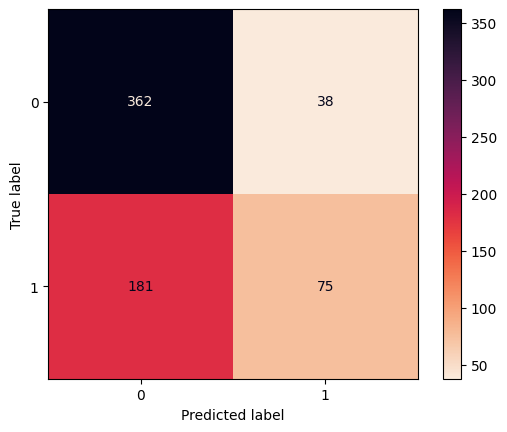

In [113]:
model = rf_final
model.fit(X_train_final, y_train_final)

y_test_pred = model.predict(X_test_final)

print(f"test accuracy: {accuracy_score(y_test_final, y_test_pred)}")

print(classification_report(y_test_final, 
                               y_test_pred, 
                               target_names=target_names, 
                               output_dict=False))
display(ConfusionMatrixDisplay.from_estimator(model, X_test_final, y_test_final, cmap='rocket_r'))

Overall the model can indicate the non-potable and potable quite better. And we can see the total of false positive and True positive are `75` and `38` respectively. In our case, False positive is more risk. Because falsely predicting non-potable water as a potable water is dangerous. In that case, we'll adjust the threshold to match for our requirements.

To see more clearly we'll visualize the trade off between false and true positve,

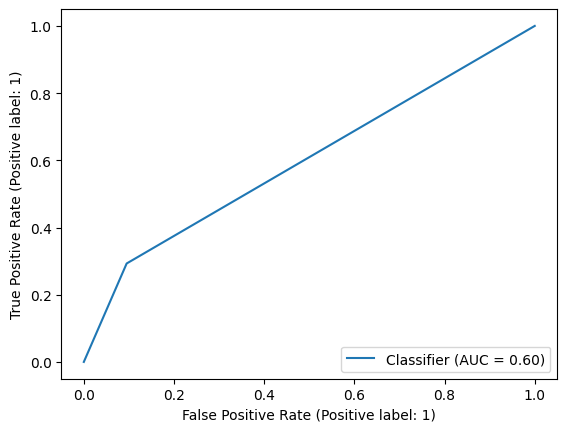

In [87]:
from sklearn.metrics import RocCurveDisplay

RocCurveDisplay.from_predictions(y_test_final, y_test_pred)

AUC = 0.60 means the ability of model randomly guessing the positive value is slightly better than a random guessing, which means the AUC=1.0 is a perfect guessing and AUC=0.5 is random guessing 

## **Classification Report**

Below the code for reporting classification metrics from precision, recall, f1-score, and accuracy, and plot the visualization through `confussion matrix` and `precision recall`. 

Anyway, we should increase the presision values, where the false positive is lowest. Hence, we define threshold uqual to `0.65`

th=0.7



,precision,recall,f1-score,support
non potable,0.622465,0.997500,0.766571,400.000000
potable,0.933333,0.054688,0.103321,256.000000
accuracy,0.629573,0.629573,0.629573,0.629573
macro avg,0.777899,0.526094,0.434946,656.000000
weighted avg,0.743779,0.629573,0.507742,656.000000


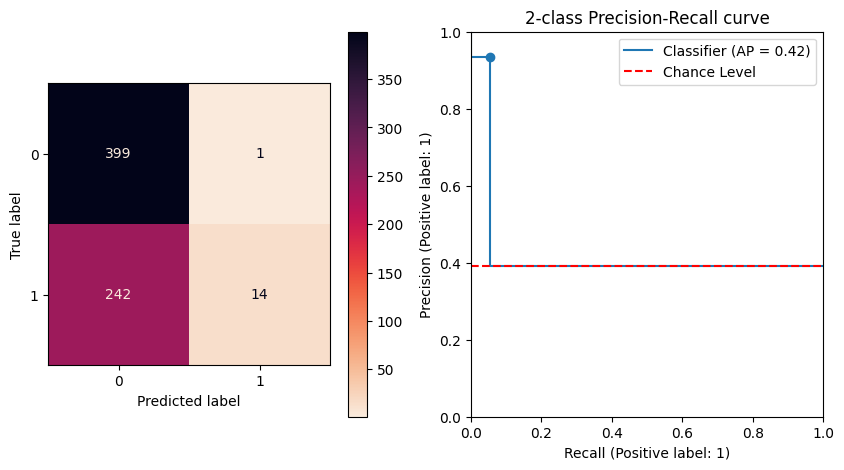

In [110]:
# Probabilities for the positive class (column 1)
y_test_proba = model.predict_proba(X_test_final)[:, 1]

# adjusting the threshold to 0.7 to be considered as a true class
threshold = 0.7

# Apply the threshold
predictions = np.where(y_test_proba > threshold, 1, 0)
target_names = ['non potable', 'potable']
report_cls = classification_report(y_test_final, 
                               predictions, 
                               target_names=target_names, 
                               output_dict=True)
print(f"th={threshold}\n")


fig, axes = plt.subplots(figsize=(10, 5), ncols=2)
axes = axes.flatten()

# display confusion matrix
display(pd.DataFrame(report_cls).T)
display(ConfusionMatrixDisplay.from_predictions(y_test_final, predictions, cmap='rocket_r', ax=axes[0]))


# precsision recall display
display_prec_rec = PrecisionRecallDisplay.from_predictions(
    y_test_final, predictions, ax=axes[1]
)
_ = display_prec_rec.ax_.set_title("2-class Precision-Recall curve")

baseline_precision = sum(y_test_final) / len(y_test_final)  # Proportion of positives
plt.axhline(y=baseline_precision, color="red", linestyle="--", label="Chance Level")
plt.scatter(x=[report_cls['potable']['recall']],
            y=[report_cls['potable']['precision']])
plt.legend()
plt.xlim(0, 1)
plt.ylim(0, 1)

display(display_prec_rec)

**Conlusion:** <br>
The precision is equal to `0.93`. Which is actually good for the model to have an false positive just around 7% of predictions. But as a trade-off the recall is very weak which the value is just `0.054`. means the model falsely predict the potable water as a non potable water around `0.95` of probability.

However, predicting non potable as a potable water *(False positive)* is more risky than the opposite. Those, from the evaluation we'll adjust the threshold equal to `0.7` to make a precision higher which means decrease the number of false positive.